# Primary Setups & Loading Baseline Models

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'data')
os.chdir(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

Like the case for former models, choose 1000 samples as train set and 1000 samples as test set.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to a [0.0, 1.0] tensor
    transforms.Lambda(lambda x: (x > 0.5).float()) # Binarizes the tensor to 0s and 1s
])

full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

all_images = full_test_dataset.data.view(-1, 784).float() / 255.0
all_labels = full_test_dataset.targets

train_images = all_images[0:1000]
train_labels = all_labels[0:1000]

test_images = all_images[1000:2000]
test_labels = all_labels[1000:2000]

print(f"Shape of our new training images: {train_images.shape}")
print(f"Shape of our new testing images:  {test_images.shape}")

train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Shape of our new training images: torch.Size([1000, 784])
Shape of our new testing images:  torch.Size([1000, 784])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Functions For Scores

In [6]:
import torch.nn.functional as F
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import sqrtm

In [7]:
def inception_score(images, classifier, batch_size=32, splits=10):
    classifier.eval()
    images = images.view(-1, 1, 28, 28)
    dataset = TensorDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            img_batch = batch[0].to(device)
            preds = F.softmax(classifier(img_batch), dim=1)
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)

    scores = []
    n_samples = all_preds.shape[0]
    split_size = n_samples // splits
    for i in range(splits):
        part = all_preds[i*split_size:(i+1)*split_size, :]
        p_yx = part
        p_y = np.mean(part, axis=0)
        kl_divs = p_yx * (np.log(p_yx + 1e-10) - np.log(p_y + 1e-10))
        kl_divs = np.sum(kl_divs, axis=1)
        scores.append(np.exp(np.mean(kl_divs)))

    return np.mean(scores), np.std(scores)

def fid_score(real_samples, gen_samples):
    act_real = get_activations(real_samples, classifier)
    act_gen  = get_activations(gen_samples, classifier)
    mu1, sigma1 = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu2, sigma2 = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def kid_score(real_samples, gen_samples):
    act_real = get_activations(real_samples, classifier)
    act_gen  = get_activations(gen_samples, classifier)
    mmd = rbf_kernel(act_real, act_real).mean() + \
          rbf_kernel(act_gen, act_gen).mean() - \
          2 * rbf_kernel(act_real, act_gen).mean()
    return mmd

## Loading Previous Models

### Classifier

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, return_features=False):
        """
        Defines the forward pass. Can return final logits or intermediate features.

        Args:
            x (torch.Tensor): The input batch of images.
            return_features (bool): If True, returns features from fc1.
                                    If False, returns final logits from fc2.
        """
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)

        features = torch.relu(self.fc1(x))

        if return_features:
            return features

        output = self.fc2(features)
        return output

In [9]:
weights_path = 'lenet_mnist.pth'
classifier = LeNet()
classifier.load_state_dict(torch.load(weights_path))
classifier.eval()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### GMM

In [ ]:
from sklearn.mixture import GaussianMixture
import joblib

In [ ]:
model_filename = 'gmm_model.joblib'
print(f"\nLoading model from {model_filename}...")
gmm = joblib.load(model_filename)
print("Model loaded successfully.")


Loading model from gmm_model.joblib...
Model loaded successfully.


Loading previous 1000 samples:

In [ ]:
filename = 'gmm_generated_samples.npy'

print(f"\nLoading samples from '{filename}'...")

gmm_samples = np.load(filename)

print("Samples loaded successfully.")


Loading samples from 'gmm_generated_samples.npy'...
Samples loaded successfully.


### NADE

In [ ]:
class NADE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512):
        """Initialize the Neural Autoregressive Density Estimation model.

        Args:
            input_dim (int): Dimension of input data (flattened image size)
            hidden_dim (int): Number of units in hidden layer
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.c = nn.Parameter(torch.zeros(hidden_dim))
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(input_dim))

        # Training metadata
        self.start_epoch = 0
        self.best_loss = float('inf')
        self.train_history = []
        self.test_history = []

    def forward(self, x):
        """Forward pass through the NADE model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            tuple: (x_hat, all_h) where:
                x_hat: reconstructed probabilities for each dimension
                all_h: all hidden states during autoregressive process
        """
        batch_size = x.size(0)
        x_hat = torch.zeros_like(x)
        all_h = []

        sum_to_d = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        for d in range(self.input_dim):
            # Compute hidden activation: a_d = c + sum_{k<d} x_k * W_k
            a_d = self.c + sum_to_d
            h_d = torch.sigmoid(a_d)

            # Compute output probability for dimension d:
            # p_d = sigmoid(b_d + V_d^T h_d)
            p_d = torch.sigmoid(self.b[d] + torch.matmul(h_d, self.V[:, d]))

            # Save prediction
            x_hat[:, d] = p_d
            all_h.append(h_d)

            # Update running sum for the next dimension
            sum_to_d += x[:, d].unsqueeze(1) * self.W[d]

        return x_hat, torch.stack(all_h, dim=1)

    def log_prob(self, x):
        """Compute log probability of input samples under the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            torch.Tensor: Log probabilities for each sample (batch_size)
        """
        x_hat, _ = self.forward(x)
        # Compute Bernoulli log likelihood:
        # log p(x) = sum_d [x_d * log(p_d) + (1-x_d) * log(1-p_d)]  --- update this in order to avoid log of zero

        x_hat = torch.clamp(x_hat, min=1e-6, max=1 - 1e-6) # avoid log(0)
        log_prob = x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat)
        # Sum over all dimensions (input_dim)
        return log_prob.sum(dim=1)


    def generate_samples(self, num_samples=10):
        """
        Generates new images via ancestral sampling
        Args:
            num_samples: How many images to generate
        Returns:
            Tensor of shape (num_samples, input_dim)
        """
        samples = torch.zeros(num_samples, 784).to(device)
        with torch.no_grad():
            for d in range(784):
                p_d = self.forward(samples)[0][:, d]
                samples[:, d] = torch.bernoulli(p_d)
        return samples.cpu()


In [ ]:
nade = NADE().to(device)
nade.load_state_dict(torch.load('nade_model.pth'))

<All keys matched successfully>

Loading the results (train_losses, test_losses, fid_history, time_history and epoch_history) from the pre-trained NADE:

In [ ]:
import json

In [ ]:
with open('nade_training_results.json', 'r') as f:
    loaded_nade_results = json.load(f)

### VAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )
        self.mu = nn.Linear(400, latent_dim)
        self.log_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        h = self.enc(x)
        return self.mu(h), self.log_var(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.dec(z)

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z)
        return recon_x, mu, log_var

In [ ]:
def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction Loss:
    # Measures how accurately the decoded output matches the original input.
    recon_loss = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence Loss:
    # Measures how much the learned latent distribution deviates
    # from a standard Gaussian distribution (prior).
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss combines both terms
    loss = recon_loss + kl_loss

    return loss, recon_loss, kl_loss

In [ ]:
# Load the saved weights into the model instance

VAE_MODEL_PATH = 'vae_model_latent20.pth'

vae = VAE(latent_dim=20).to(device)
vae.load_state_dict(torch.load(VAE_MODEL_PATH))

<All keys matched successfully>

Loading the results (train_losses, test_losses, fid_history, time_history and epoch_history) from the pre-trained VAE:

In [ ]:
RESULTS_PATH = 'vae_training_results.json'

with open(RESULTS_PATH, 'r') as f:
    loaded_vae_results = json.load(f)

# Training The New Models

In order to have a fair comparison, the same number of epochs (=100) is set for the training of these newer models

## Normalizing Flow (NICE)

In [10]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=1000, n_hidden=2):
        super(MLP, self).__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class NICE(nn.Module):
    def __init__(self, input_dim, hidden_dim=1000, n_coupling_layers=4):
        super(NICE, self).__init__()
        self.input_dim = input_dim
        self.n_coupling_layers = n_coupling_layers

        # Each coupling layer gets its own MLP
        self.coupling_layers = nn.ModuleList([
            MLP(input_dim // 2, input_dim // 2, hidden_dim=hidden_dim)
            for _ in range(n_coupling_layers)
        ])

        # Diagonal scaling
        self.scaling = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        z = x
        for i, net in enumerate(self.coupling_layers):
            z1, z2 = z.chunk(2, dim=1)
            if i % 2 == 0:
                z2 = z2 + net(z1)
            else:
                z1 = z1 + net(z2)
            z = torch.cat([z1, z2], dim=1)
        z = z * torch.exp(self.scaling)
        return z

    def inverse(self, z):
        x = z * torch.exp(-self.scaling)
        for i, net in reversed(list(enumerate(self.coupling_layers))):
            x1, x2 = x.chunk(2, dim=1)
            if i % 2 == 0:
                x2 = x2 - net(x1)
            else:
                x1 = x1 - net(x2)
            x = torch.cat([x1, x2], dim=1)
        return x

    def log_prob(self, x):
        z = self.forward(x)
        log_det = torch.sum(self.scaling)
        log_base = -0.5 * torch.sum(z ** 2, dim=1)
        log_base -= 0.5 * self.input_dim * torch.log(torch.tensor(2 * torch.pi))
        return log_base + log_det

    def sample(self, n):
        z = torch.randn(n, self.input_dim)
        return self.inverse(z)

In [11]:
import time

In [ ]:
INPUT_DIM = 28 * 28
LR = 1e-4
NUM_EPOCHS = 100

model = NICE(input_dim=INPUT_DIM, hidden_dim=1024, n_coupling_layers=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

print("\nStarting NICE training...")

train_losses = []
test_losses = []
time_history = []
epoch_history = []

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, INPUT_DIM).to(device)
        # Normalize to [0, 1] and add a small epsilon for numerical stability
        batch = (batch + torch.rand_like(batch) * 0.01) / 1.01

        optimizer.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, _ in test_loader:
            batch = batch.view(-1, INPUT_DIM).to(device)
            batch = (batch + torch.rand_like(batch) * 0.01) / 1.01
            loss = -model.log_prob(batch).mean()
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    elapsed_time = time.time() - start_time
    time_history.append(elapsed_time)
    epoch_history.append(epoch + 1)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

end_time = time.time()


Starting NICE training...
Epoch [1/100] - Train Loss: 751.4590 | Test Loss: 743.1682
Epoch [2/100] - Train Loss: 741.8485 | Test Loss: 740.2394
Epoch [3/100] - Train Loss: 739.0319 | Test Loss: 737.8193
Epoch [4/100] - Train Loss: 736.6015 | Test Loss: 735.6566
Epoch [5/100] - Train Loss: 734.0566 | Test Loss: 733.2300
Epoch [6/100] - Train Loss: 731.2603 | Test Loss: 730.6059
Epoch [7/100] - Train Loss: 728.5596 | Test Loss: 728.2004
Epoch [8/100] - Train Loss: 726.0458 | Test Loss: 725.8896
Epoch [9/100] - Train Loss: 723.7877 | Test Loss: 723.8682
Epoch [10/100] - Train Loss: 721.6456 | Test Loss: 721.8592
Epoch [11/100] - Train Loss: 719.5551 | Test Loss: 719.9788
Epoch [12/100] - Train Loss: 717.6783 | Test Loss: 718.1059
Epoch [13/100] - Train Loss: 715.7578 | Test Loss: 716.4549
Epoch [14/100] - Train Loss: 714.0039 | Test Loss: 714.6589
Epoch [15/100] - Train Loss: 712.2221 | Test Loss: 713.0396
Epoch [16/100] - Train Loss: 710.5557 | Test Loss: 711.4291
Epoch [17/100] - Train

In [ ]:
nf_train_time = end_time - start_time
print(f"Training time for NICE: {nf_train_time} seconds")

Training time for NICE: 13.607468366622925 seconds


In [6]:
import matplotlib.pyplot as plt

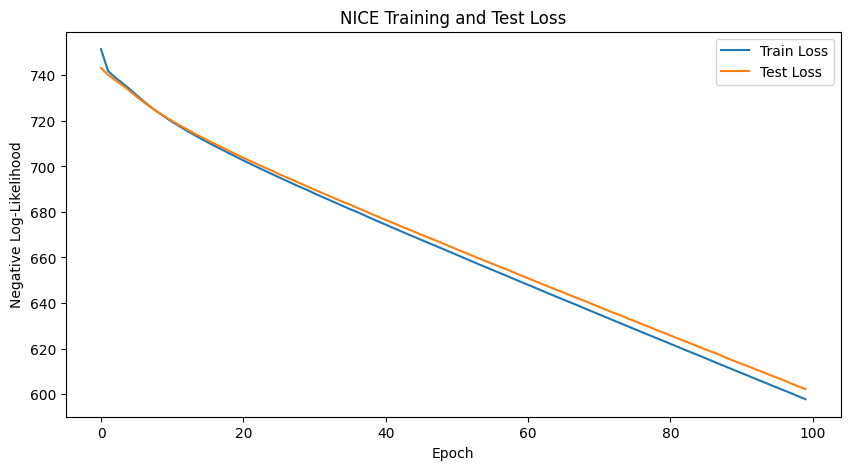

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("NICE Training and Test Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'nice_mnist_model.pth')
print("Model saved to nice_mnist_model.pth")

Model saved to nice_mnist_model.pth


In [12]:
# INPUT_DIM = 28 * 28
# loaded_nice = NICE(input_dim=INPUT_DIM, hidden_dim=1024, n_coupling_layers=4)

# loaded_nice.load_state_dict(torch.load('nice_mnist_model.pth'))

# loaded_nice.to(device)
# loaded_nice.eval()

# print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
nice_results_to_save = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'time_history': time_history,
    'epoch_history': epoch_history
}

NICE_RESULTS_PATH = 'nice_training_results.json'
print(f"\nSaving NICE training results to {NICE_RESULTS_PATH}...")

with open(NICE_RESULTS_PATH, 'w') as f:
    json.dump(nice_results_to_save, f, indent=4)
print("NICE results saved successfully.")


Saving NICE training results to nice_training_results.json...
NICE results saved successfully.


In [ ]:
# RESULTS_PATH = 'nice_training_results.json'

# with open(RESULTS_PATH, 'r') as f:
#     loaded_nice_results = json.load(f)

## GAN

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size, hidden_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        # Reshape the output to be a 28x28 image
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten the input image for the fully-connected layers
        x = x.view(-1, image_size)
        return self.main(x)

In [ ]:
latent_dim = 100
image_size = 784
hidden_dim = 256
lr = 0.0001
num_epochs = 100

generator = Generator(latent_dim, image_size, hidden_dim).to(device)
discriminator = Discriminator(image_size, hidden_dim).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

train_g_losses = []
train_d_losses = []
test_g_losses = []
test_d_losses = []
epoch_history = []
time_history = []

start_time = time.time()

print("\nStarting GAN training and evaluation...")

for epoch in range(num_epochs):
    # Training Phase
    generator.train()
    discriminator.train()
    epoch_train_d_loss = 0
    epoch_train_g_loss = 0

    for i, (real_images, _) in enumerate(train_loader):
        batch_size_current = real_images.size(0)
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size_current, 1).to(device)
        fake_labels = torch.zeros(batch_size_current, 1).to(device)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(real_images)
        loss_d_real = criterion(real_outputs, real_labels)
        z = torch.randn(batch_size_current, latent_dim).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        loss_d_fake = criterion(fake_outputs, fake_labels)
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d.step()
        epoch_train_d_loss += loss_d.item()

        # Train Generator
        optimizer_g.zero_grad()
        z = torch.randn(batch_size_current, latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        loss_g = criterion(outputs, real_labels)
        loss_g.backward()
        optimizer_g.step()
        epoch_train_g_loss += loss_g.item()

    avg_train_d_loss = epoch_train_d_loss / len(train_loader)
    avg_train_g_loss = epoch_train_g_loss / len(train_loader)
    train_d_losses.append(avg_train_d_loss)
    train_g_losses.append(avg_train_g_loss)

    # Evaluation Phase
    generator.eval()
    discriminator.eval()
    epoch_test_d_loss = 0
    epoch_test_g_loss = 0

    with torch.no_grad():
        for real_images, _ in test_loader:
            batch_size_current = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = torch.ones(batch_size_current, 1).to(device)
            fake_labels = torch.zeros(batch_size_current, 1).to(device)

            # Calculate Discriminator Loss
            real_outputs = discriminator(real_images)
            loss_d_real = criterion(real_outputs, real_labels)
            z = torch.randn(batch_size_current, latent_dim).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images)
            loss_d_fake = criterion(fake_outputs, fake_labels)
            loss_d = loss_d_real + loss_d_fake
            epoch_test_d_loss += loss_d.item()

            # Calculate Generator Loss
            outputs = discriminator(fake_images)
            loss_g = criterion(outputs, real_labels)
            epoch_test_g_loss += loss_g.item()

    avg_test_d_loss = epoch_test_d_loss / len(test_loader)
    avg_test_g_loss = epoch_test_g_loss / len(test_loader)
    test_d_losses.append(avg_test_d_loss)
    test_g_losses.append(avg_test_g_loss)

    elapsed_time = time.time() - start_time
    time_history.append(elapsed_time)
    epoch_history.append(epoch + 1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train D Loss: {avg_train_d_loss:.4f} | Train G Loss: {avg_train_g_loss:.4f} | Test D Loss: {avg_test_d_loss:.4f} | Test G Loss: {avg_test_g_loss:.4f} | Time Elapsed: {elapsed_time:.2f}s")

end_time = time.time()



Starting GAN training and evaluation...
Epoch [1/100] - Train D Loss: 1.2804 | Train G Loss: 0.6493 | Test D Loss: 1.1920 | Test G Loss: 0.6103 | Time Elapsed: 0.12s
Epoch [2/100] - Train D Loss: 1.1836 | Train G Loss: 0.5528 | Test D Loss: 1.2361 | Test G Loss: 0.4631 | Time Elapsed: 0.23s
Epoch [3/100] - Train D Loss: 1.2693 | Train G Loss: 0.5151 | Test D Loss: 1.2706 | Test G Loss: 0.5441 | Time Elapsed: 0.34s
Epoch [4/100] - Train D Loss: 1.3148 | Train G Loss: 0.7969 | Test D Loss: 1.4480 | Test G Loss: 0.7735 | Time Elapsed: 0.47s
Epoch [5/100] - Train D Loss: 1.4770 | Train G Loss: 0.9960 | Test D Loss: 1.3386 | Test G Loss: 0.9551 | Time Elapsed: 0.58s
Epoch [6/100] - Train D Loss: 1.0877 | Train G Loss: 1.2402 | Test D Loss: 0.8364 | Test G Loss: 1.1519 | Time Elapsed: 0.69s
Epoch [7/100] - Train D Loss: 0.7747 | Train G Loss: 1.2791 | Test D Loss: 0.8251 | Test G Loss: 0.8738 | Time Elapsed: 0.80s
Epoch [8/100] - Train D Loss: 1.0098 | Train G Loss: 0.8698 | Test D Loss: 1.

In [ ]:
gam_train_time = end_time - start_time
print(f"Training time for GAM: {gam_train_time} seconds")

Training time for GAM: 11.791095972061157 seconds


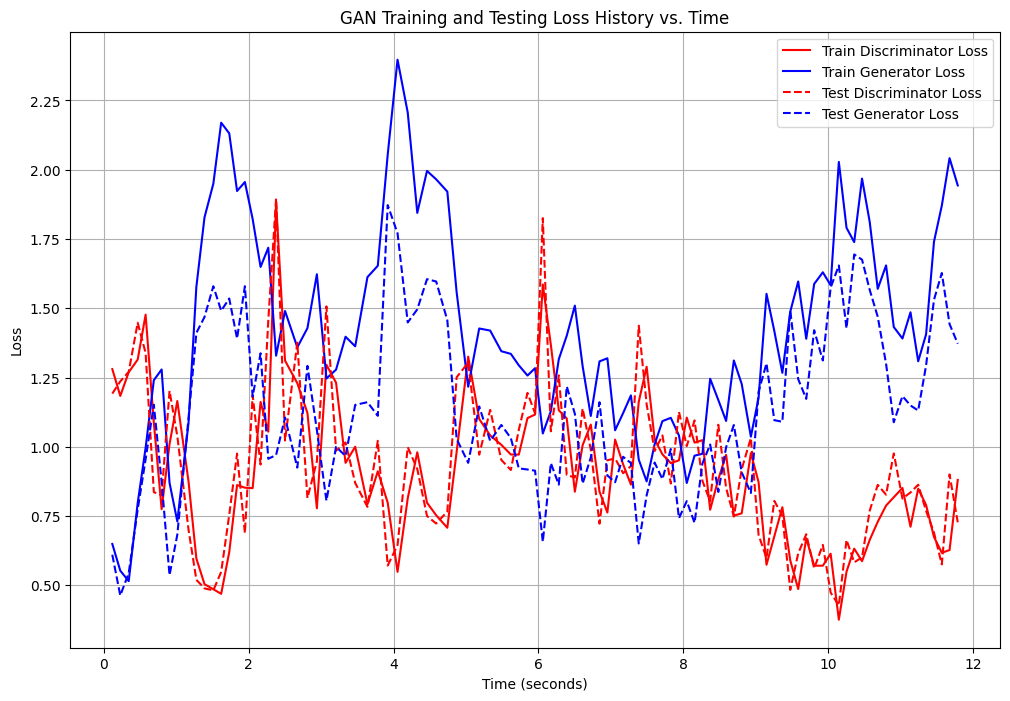

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(time_history, train_d_losses, label='Train Discriminator Loss', color='red', linestyle='-')
plt.plot(time_history, train_g_losses, label='Train Generator Loss', color='blue', linestyle='-')
plt.plot(time_history, test_d_losses, label='Test Discriminator Loss', color='red', linestyle='--')
plt.plot(time_history, test_g_losses, label='Test Generator Loss', color='blue', linestyle='--')
plt.title('GAN Training and Testing Loss History vs. Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [ ]:
torch.save(generator.state_dict(), 'gam_generator_mnist_model.pth')
print("Model saved to gam_generator_mnist_model.pth")

torch.save(discriminator.state_dict(), 'gam_discriminator_mnist_model.pth')
print("Model saved to gam_discriminator_mnist_model.pth")

Model saved to gam_generator_mnist_model.pth
Model saved to gam_discriminator_mnist_model.pth


In [14]:
# latent_dim = 100
# image_size = 784
# hidden_dim = 256

# loaded_generator = Generator(latent_dim, image_size, hidden_dim)
# loaded_discriminator = Discriminator(image_size, hidden_dim)

# loaded_generator.load_state_dict(torch.load('gam_generator_mnist_model.pth'))
# loaded_generator.to(device)
# loaded_generator.eval()

# loaded_discriminator.load_state_dict(torch.load('gam_discriminator_mnist_model.pth'))
# loaded_discriminator.to(device)
# loaded_discriminator.eval()

# print("Models loaded successfully!")

Models loaded successfully!


In [ ]:
gam_results_to_save = {
    'train_g_losses': train_g_losses,
    'test_g_losses': test_g_losses,
    'train_d_losses': train_d_losses,
    'test_d_losses': test_d_losses,
    'time_history': time_history,
    'epoch_history': epoch_history
}

GAM_RESULTS_PATH = 'gam_training_results.json'
print(f"\nSaving NICE training results to {GAM_RESULTS_PATH}...")

with open(GAM_RESULTS_PATH, 'w') as f:
    json.dump(gam_results_to_save, f, indent=4)
print("GAM results saved successfully.")


Saving NICE training results to gam_training_results.json...
GAM results saved successfully.


In [ ]:
# RESULTS_PATH = 'gam_training_results.json'

# with open(RESULTS_PATH, 'r') as f:
#     loaded_gam_results = json.load(f)

## EBM

In [15]:
class EnergyFunction(nn.Module):
    def __init__(self, image_size, hidden_dim=256):
        super(EnergyFunction, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)  # scalar energy
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        return self.main(x)

In [16]:
def sgld_sample(model, x_init, steps=60, step_size=10.0, noise_scale=0.005, constrain=False):
    """
    SGLD sampler similar to TensorFlow version.
    """
    x = x_init.clone().detach().to(x_init.device)
    x.requires_grad_(True)

    for _ in range(steps):
        energy = model(x).sum()
        grad = torch.autograd.grad(energy, x, retain_graph=False, create_graph=False)[0]

        # Langevin update
        x = x - 0.5 * step_size * grad
        x = x + noise_scale * torch.randn_like(x)

        if constrain:
            x = torch.clamp(x, 0.0, 1.0)

        x = x.detach().requires_grad_(True)

    return x.detach()

In [10]:
image_size=784
idden_dim=256
lr=1e-4
num_epochs=100
mcmc_steps=60
mcmc_lr=10.0

energy_model = EnergyFunction(image_size).to(device)
optimizer = optim.Adam(energy_model.parameters(), lr=lr)

train_losses = []
test_losses = []
epoch_history = []
time_history = []

replay_buffer_size = 10000
replay_buffer = torch.rand(replay_buffer_size, image_size, device=device)

print("\nStarting EBM training...")

start_time = time.time()

for epoch in range(num_epochs):
  energy_model.train()
  epoch_train_loss = 0

  for real_images, _ in train_loader:
      real_images = real_images.view(real_images.size(0), -1).to(device)

      batch_size = real_images.size(0)
      num_uniform = int(0.05 * batch_size)
      num_buffer = batch_size - num_uniform

      uniform_samples = torch.rand(num_uniform, image_size, device=device)
      buffer_indices = torch.randint(0, replay_buffer_size, (num_buffer,), device=device)
      buffer_samples = replay_buffer[buffer_indices]

      x_init = torch.cat([uniform_samples, buffer_samples], dim=0)

      x_fake = sgld_sample(energy_model, x_init, steps=mcmc_steps, step_size=mcmc_lr)

      replay_buffer[buffer_indices] = x_fake[num_uniform:].detach()

      optimizer.zero_grad()
      real_energy = energy_model(real_images)
      fake_energy = energy_model(x_fake)
      loss = real_energy.mean() - fake_energy.mean()
      loss.backward()
      optimizer.step()

      epoch_train_loss += loss.item()

  avg_train_loss = epoch_train_loss / len(train_loader)
  train_losses.append(avg_train_loss)

  # Evaluation Phase
  energy_model.eval()
  epoch_test_loss = 0


  for real_images, _ in test_loader:
      real_images = real_images.view(real_images.size(0), -1).to(device)
      x_init = torch.rand_like(real_images, device=device)
      x_fake = sgld_sample(energy_model, x_init, steps=mcmc_steps, step_size=mcmc_lr)

      with torch.no_grad():
        real_energy = energy_model(real_images)
        fake_energy = energy_model(x_fake)
        loss = real_energy.mean() - fake_energy.mean()
        epoch_test_loss += loss.item()

  avg_test_loss = epoch_test_loss / len(test_loader)
  test_losses.append(avg_test_loss)

  elapsed_time = time.time() - start_time
  time_history.append(elapsed_time)
  epoch_history.append(epoch + 1)

  print(f"Epoch [{epoch+1}/{num_epochs}] - "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Test Loss: {avg_test_loss:.4f} | "
        f"Time Elapsed: {elapsed_time:.2f}s")

print("\nTraining complete!")


Starting EBM training...
Epoch [1/100] - Train Loss: 0.4932 | Test Loss: 0.0698 | Time Elapsed: 1.16s
Epoch [2/100] - Train Loss: 0.1529 | Test Loss: 0.0094 | Time Elapsed: 2.33s
Epoch [3/100] - Train Loss: 0.1341 | Test Loss: -0.0131 | Time Elapsed: 3.58s
Epoch [4/100] - Train Loss: 0.0796 | Test Loss: 0.0039 | Time Elapsed: 4.82s
Epoch [5/100] - Train Loss: 0.0583 | Test Loss: -0.0081 | Time Elapsed: 6.13s
Epoch [6/100] - Train Loss: 0.0377 | Test Loss: -0.0197 | Time Elapsed: 7.28s
Epoch [7/100] - Train Loss: 0.0311 | Test Loss: -0.0248 | Time Elapsed: 8.43s
Epoch [8/100] - Train Loss: 0.0220 | Test Loss: -0.0322 | Time Elapsed: 9.56s
Epoch [9/100] - Train Loss: 0.0181 | Test Loss: -0.0300 | Time Elapsed: 10.70s
Epoch [10/100] - Train Loss: 0.0143 | Test Loss: -0.0284 | Time Elapsed: 11.86s
Epoch [11/100] - Train Loss: 0.0134 | Test Loss: -0.0284 | Time Elapsed: 13.01s
Epoch [12/100] - Train Loss: 0.0096 | Test Loss: -0.0272 | Time Elapsed: 14.14s
Epoch [13/100] - Train Loss: 0.010

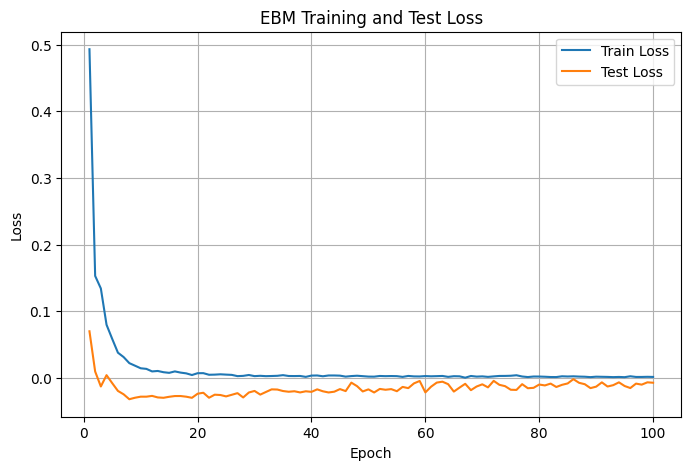

In [13]:
plt.figure(figsize=(8,5))
plt.plot(epoch_history, train_losses, label="Train Loss")
plt.plot(epoch_history, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EBM Training and Test Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
torch.save(energy_model.state_dict(), "energy_model_mnist.pth")
print("Model saved to energy_model_mnist.pth")

Model saved to energy_model_mnist.pth


In [17]:
# image_size = 784
# energy_model = EnergyFunction(image_size).to(device)

# energy_model.load_state_dict(torch.load("energy_model_mnist.pth", map_location=device))
# energy_model.eval()

EnergyFunction(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
ebm_results_to_save = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'time_history': time_history,
    'epoch_history': epoch_history
}

EBM_RESULTS_PATH = 'ebm_training_results.json'
print(f"\nSaving EBM training results to {EBM_RESULTS_PATH}...")

with open(EBM_RESULTS_PATH, 'w') as f:
    json.dump(ebm_results_to_save, f, indent=4)
print("EBM results saved successfully.")


Saving EBM training results to ebm_training_results.json...
EBM results saved successfully.


In [ ]:
# RESULTS_PATH = 'ebm_training_results.json'

# with open(RESULTS_PATH, 'r') as f:
#     loaded_ebm_results = json.load(f)

# Sample Generation & Verification

## Sampling

In [18]:
n_samples = 1000


t1 = time.time()

loaded_nice.eval()
with torch.no_grad():
    z = torch.randn(n_samples, loaded_nice.input_dim, device=device)
    nf_samples = loaded_nice.inverse(z)
    nf_samples = nf_samples.view(-1, 1, 28, 28)

t2 = time.time()

loaded_generator.eval()
latent_dim = 100
z = torch.randn(n_samples, latent_dim, device=device)
gan_samples = loaded_generator(z)

t3 = time.time()

energy_model.eval()
batch_size = 64
image_size = 784
x_init = torch.rand(batch_size, image_size, device=device)

t4 = time.time()

ebm_samples = sgld_sample(energy_model, x_init, steps=60, step_size=10.0, noise_scale=0.005)

In [29]:
nf_sampling_time = t2 - t1
gan_sampling_time = t3 - t2
ebm_sampling_time = t4 - t3

print(f"Sampling time for 100 samples from NICE: {nf_sampling_time} second(s)")
print(f"Sampling time for 100 samples from GAN: {gan_sampling_time} second(s)")
print(f"Sampling time for 100 samples from EBM: {ebm_sampling_time} second(s)")

Sampling time for 100 samples from NICE: 0.3343212604522705 second(s)
Sampling time for 100 samples from GAN: 0.023687362670898438 second(s)
Sampling time for 100 samples from EBM: 0.011350154876708984 second(s)


In [19]:
def save_samples(samples, filename):
    """
    Save torch samples as a .pt file.
    """
    torch.save(samples.cpu(), filename)
    print(f"Saved samples with name: {filename}")

In [20]:
save_samples(nf_samples, "nice_samples.pt")
save_samples(gan_samples, "gan_samples.pt")
save_samples(ebm_samples, "ebm_samples.pt")

Saved samples with name: nice_samples.pt
Saved samples with name: gan_samples.pt
Saved samples with name: ebm_samples.pt


In [ ]:
# nice_samples = torch.load("samples/nice_samples.pt")
# gan_samples  = torch.load("samples/gan_samples.pt")
# ebm_samples  = torch.load("samples/ebm_samples.pt")

In [21]:
import random

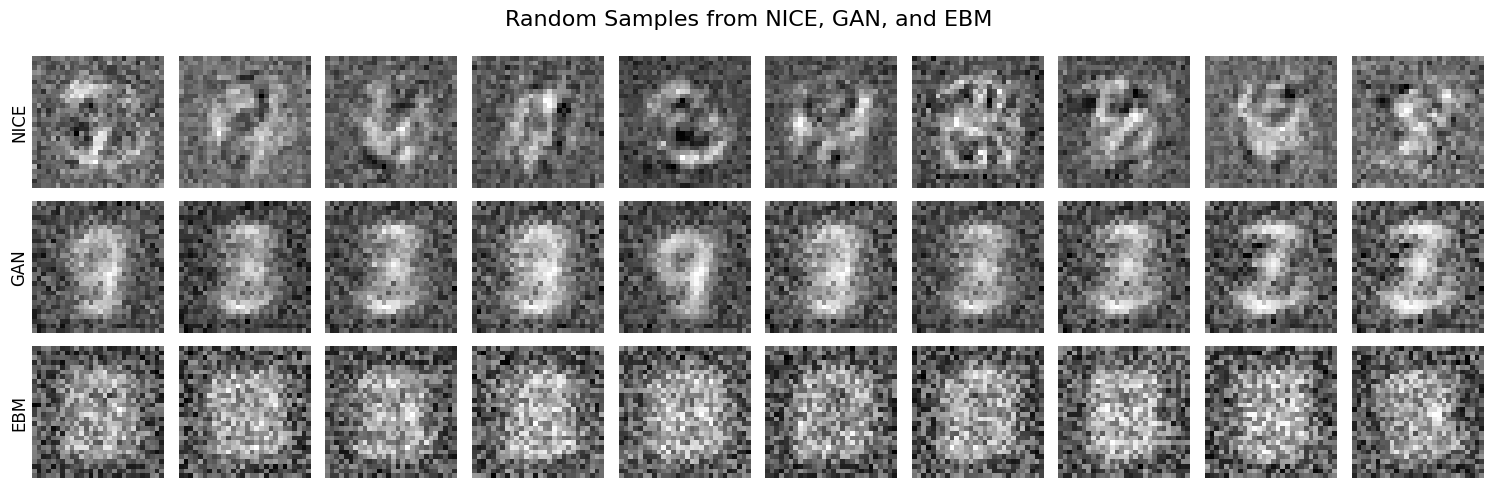

In [24]:
def select_random(samples, n=10):
    idxs = random.sample(range(len(samples)), n)
    return samples[idxs].detach()


nf_imgs = select_random(nf_samples, 10)
gan_imgs = select_random(gan_samples, 10)
ebm_imgs = select_random(ebm_samples, 10)

H, W = 28, 28
if ebm_imgs.dim() == 2:
    ebm_imgs = ebm_imgs.view(-1, 1, H, W)

all_samples = torch.cat([nf_imgs, gan_imgs, ebm_imgs], dim=0)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
fig.suptitle("Random Samples from NICE, GAN, and EBM", fontsize=16)

row_labels = ["NICE", "GAN", "EBM"]

for i in range(3):
    for j in range(10):
        idx = i * 10 + j
        axes[i, j].imshow(all_samples[idx].squeeze().cpu().numpy(), cmap="gray")
        axes[i, j].axis("off")
    axes[i, 0].text(-0.1, 0.5, row_labels[i], fontsize=12, rotation=90,
                    va='center', ha='center', transform=axes[i, 0].transAxes)

plt.tight_layout()
plt.show()

The digits are not recognizable at all in the samples from NICE and EBM. GAN's samples have somewhat recognizable digits. The fact that only digits "3" and "9" can be seen in the 10 samples might be due to the "mode collapse" problem of GAN. </br>
The overall inadequacy of the samples could be because of the low number of training epochs; a limitations which was forced because of the simulation on the former slower models.

# Quantitative Evaluation

In [30]:
real_samples = next(iter(test_loader))[0][:1000].to(device)

In [31]:
def get_activations(images, classifier, batch_size=32):
    classifier.eval()
    images = images.view(-1, 1, 28, 28)
    dataset = TensorDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    acts = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            act = classifier.features(x) if hasattr(classifier, "features") else classifier(x)
            acts.append(act.cpu().numpy())

    return np.concatenate(acts, axis=0)

In [38]:
classifier = classifier.to(device)
classifier.eval()

models = {"NICE": nf_samples, "GAN": gan_samples, "EBM": ebm_samples}

for name, samples in models.items():
    samples = samples.to(device)

    is_mean, is_std = inception_score(samples, classifier)
    fid_val = fid_score(real_samples.to(device), samples)
    kid_val = kid_score(real_samples.to(device), samples)

    print(f"{name} -> IS: {is_mean:.4f} ± {is_std:.4f}, FID: {fid_val:.4f}, KID: {kid_val:.4f}")

NICE -> IS: 6.6750 ± 0.4799, FID: 2331.9444, KID: 0.0108
GAN -> IS: 1.6715 ± 0.0587, FID: 326.9087, KID: 0.2026
EBM -> IS: 1.3814 ± 0.1460, FID: 364.9936, KID: 0.1404


| Model | Inception Score (IS) | FID    | KID    |
|-------|--------------------|--------|--------|
| GAM   |1.0000|0.0047|0.0001|
| VAE   |1.0000|0.0040|0.0001|
| NADE  |1.0000|0.0091|0.0003|
| NF    |6.6750|2331.9444|0.0108|
| GAN   |1.6715|326.9087|0.2026|
| EBM   |1.3814|364.9936|0.01404|

**IS**
- GAM, VAE, NADE all sit at 1.0 -> they’re generating nearly constant / non-diverse outputs.
- NF achieves 6.67 -> looks strong in diversity & classifiability, but IS alone is misleading.

**FID**
- GAM, VAE, NADE all give extremely low FID (lower than 0.01). This might be collapsing to constant images that trivially reduce FID.
- NF: 2331.9 -> huge; meaning the generated distribution is far from real.
- EBM: 364.9 -> similar order with GAN, slightly worse than GAN.

**KID**
- GAM, VAE, NADE again look artificially good (lower than 0.0003). Same suspicion: trivial solutions.
- EBM: 0.0140 -> actually much better than GAN and closer to NF, showing that EBMs produce more realistic samples than GAN under KID, even if IS and FID disagree.

# Computational Tradeoffs

| Model | Sampling Time for 100 Samples (s) |
|-------|--------------------|
| GAM   |0.003467|
| VAE   |0.006496|
| NADE  |98.318010|
| NF    |0.334321|
| GAN   |0.023687|
| EBM   |0.011350|

Among all 6 models, NADE has the slowest sampling speed (because of the fact that the components of each sample is generated sequentially by chain rule) and GAM has the fastest sampling speed (as it is a simple parametric model and has basically zero sampling overhead).